In [41]:
from v2x import V2XData
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
import sklearn.metrics as skm
from tsai.all import *
from fastai.callback.wandb import *
import wandb
my_setup(wandb)
wandb.login()

config_default = AttrDict(
    batch_tfms = TSStandardize(by_sample=True),
    arch_config = {},
    architecture = LSTM,
    lr = 1e-3,
    n_epochs = 20,
)

os              : Windows-10-10.0.19044-SP0
python          : 3.9.12
tsai            : 0.3.4
fastai          : 2.7.10
fastcore        : 1.5.27
wandb           : 0.13.5
torch           : 1.12.0
device          : 1 gpu (['NVIDIA GeForce GTX 1070 Ti'])
cpu cores       : 6
threads per cpu : 1
RAM             : 23.95 GB
GPU memory      : [8.0] GB


In [42]:
files_path = './data/Sejong'
v2xdata = V2XData(files_path, hazard_thr=3)


loaded 46 files
['./data/Sejong\\0901_5RNBVU80.csv', './data/Sejong\\0901_OKG5RJW0.csv', './data/Sejong\\0902_5RNBVU80.csv', './data/Sejong\\0902_9CU6AVIU.csv', './data/Sejong\\0903_5RNBVU80.csv'] ...


df[2] shape: (10459, 11)
X      - shape: [1045 samples x 9 features x 10 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (1045,)  type: ndarray  dtype:int32  isnan: 0
splits - n_splits: 2 shape: [522, 523]  overlap: False


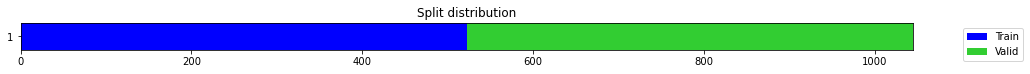

files index: 0 ~ 46


100%|██████████| 46/46 [00:13<00:00,  3.31it/s]

X_sum shape: (35300, 9, 10), y_sum shape: (35300,)
X      - shape: [35300 samples x 9 features x 10 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (35300,)  type: ndarray  dtype:int32  isnan: 0
splits - n_splits: 2 shape: [17650, 17650]  overlap: False


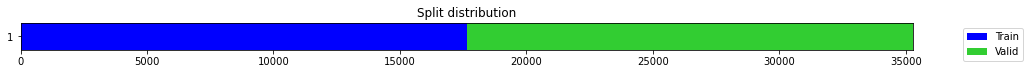

In [43]:
X, y, splits, df = v2xdata[2]
check_data(X, y, splits=splits)
X_all, y_all, splits, df_all = v2xdata.get_all_item()
check_data(X_all, y_all, splits=splits)

In [44]:
df.head(3)

,HEADING,SPEED,HAZARDLIGHTS_FLAG,HARDBRAKING_FLAG,LIGHTSCHANGE_FLAG,HARDDECELERATION_FLAG,UTURN_FLAG,LIGHTS_STATUS,CURRENT_LANE,scene,Hazard
0,-1.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,scene_3,False
1,-1.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,scene_3,False
2,-1.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,scene_3,False


In [45]:
for col in df_all.columns:
    ignore_col = ['HEADING', 'SPEED', 'X', 'Y', 'scene', 'Hazard']
    if col in ignore_col:
        continue
    print(f'{col}: {df_all[col].unique()}')

HAZARDLIGHTS_FLAG: [ 0.  1. -1.  2. -2.]
HARDBRAKING_FLAG: [ 0.  1. -1.  2. -2.]
LIGHTSCHANGE_FLAG: [ 0.  1. -1.  2. -2.]
HARDDECELERATION_FLAG: [ 0.  1. -1.]
UTURN_FLAG: [ 0.  1. -1.]
LIGHTS_STATUS: [  0.   4.   8.  -4.  -8.  16. -16. -12.  12.  28. -28. -20.  24. -24.
  20.]
CURRENT_LANE: [ 0.  4. -4.  3.  2. -3. -2. -1.  1. -5.  6. -6.  5. -7.  7.  8.]


In [46]:
from v2x import V2XData
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
import sklearn.metrics as skm
from tsai.all import *

def learn_model(X, y, splits, model_input, epochs):
    # train with LSTM
    tfms = [TSStandardize(verbose=True), [Categorize()]]
    batch_tfms = TSStandardize(by_sample=True)
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
    dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=64, batch_tfms=batch_tfms)
    dls.show_batch()

    model = create_model(model_input, dls = dls)
    learn = Learner(dls, model, metrics=accuracy)
    learn.fit_one_cycle(epochs, 1e-3)
    learn.plot_metrics()
    
def multivariate_classification(X, y, splits, config=config_default, metrics=accuracy, lr_find=False, load_ckpt = False
                                , save: str = 'multivariate_classification'):
    "model_input: LSTM, LSTMPlus, MLSTM_Plus, LSTM_FCN"
    
    tfms = [None, [TSCategorize()]]
    check_data(X, y, splits=splits)
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
    dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=256, batch_tfms=config["batch_tfms"])
    
    m = create_model(config["architecture"], dls = dls)
    learn = Learner(dls, m, metrics=metrics)
    if lr_find:
        learn.lr_find()
    learn.fit(config["n_epochs"], config["lr"], cbs=SaveModel(monitor='accuracy', fname=save))
    learn.recorder.plot_metrics()
    learn.save('classification')
    return learn

def multivariate_classification_wandb(X, y, splits, metrics=accuracy, config = config_default, proj_name = "50-1 V2X TSClassification", lr_find=False, load_ckpt = False
                                , save: str = 'multivariate_classification'):
    "model_input: LSTM, LSTMPlus, MLSTM_Plus, LSTM_FCN"
    with wandb.init(project="multivariate_classification", config=config, name = proj_name) as run:
        # wandb records every epoch
        tfms = [None, [TSCategorize()]]
        check_data(X, y, splits=splits)
        dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
        cbs = [ShowGraph(), WandbCallback(log_preds=False, log_model=False)]
        dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=256, batch_tfms=config["batch_tfms"])
        
        m = create_model(config["architecture"], dls = dls)
        learn = Learner(dls, m, metrics=metrics)
        if lr_find:
            learn.lr_find()
        learn.fit(config["n_epochs"], config["lr"], cbs=cbs)
        learn.recorder.plot_metrics()
        learn.save('classification')
        return learn
    
def minirocket_classification(X, y, splits, epochs=20, model=MiniRocketPlus, lr = 1e-3, metrics=accuracy, lr_find=False, save: str = 'minirocket_classification'):
    tfms = [None, [Categorize()]]
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
    batch_tfms = TSStandardize(by_sample=True)
    dls = get_ts_dls(X, y, bs=256, tfms=tfms, batch_tfms=batch_tfms, splits=splits)
    
    m = create_model(model, dls = dls)
    learn = ts_learner(dls, m, kernel_size=len(X[0]), metrics=metrics)
    if lr_find:
        learn.lr_find()
    learn.fit(epochs, lr)
    learn.recorder.plot_metrics()
    if save:
        learn.save(save)
    return learn

def multivariate_forecasting(X, y, splits, epochs=20, model=LSTM, lr = 1e-3, metrics=mae, lr_find=False):
    "model_input: LSTM, LSTMPlus, MLSTM_Plus, LSTM_FCN"
    splits = TSSplitter()(y)
    tfms = [None, [TSRegression()]]
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
    batch_tfms = TSStandardize(by_var=True)
    dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
    
    m = create_model(model, dls = dls)
    learn = TSForecaster(X, y, splits=splits, batch_tfms=batch_tfms, arch=None, arch_config=dict(fc_dropout=.2), metrics=metrics, bs=512,
                         partial_n=.1, train_metrics=True)
    if lr_find:
        learn.lr_find()
    learn.fit(epochs, lr)
    learn.recorder.plot_metrics()
    learn.save('forecasting')
    return learn

In [47]:
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred) # 오차행렬
    accuracy = accuracy_score(y_test, pred) # 정확도
    precision = precision_score(y_test, pred) # 정밀도
    recall = recall_score(y_test, pred) # 재현율
    f1 = f1_score(y_test, pred) # f1 score
    print(f'오차행렬 : \n{confusion}\n\nTN = {confusion[0, 0]}, FP = {confusion[0, 1]}\nFN = {confusion[1, 0]}, TP = {confusion[1, 1]}\n')
    print(f'정확도 : {round(accuracy, 4)} \n정밀도 : {round(precision, 4)} \n재현율 : {round(recall, 4)} \nF1 score : {round(f1, 4)}')

# train

X      - shape: [1045 samples x 9 features x 10 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (1045,)  type: ndarray  dtype:int32  isnan: 0
splits - n_splits: 2 shape: [17650, 17650]  overlap: False


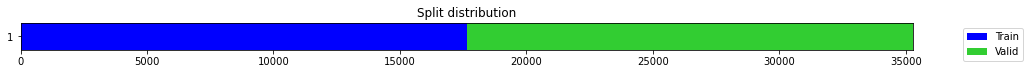

IndexError: index 1045 is out of bounds for axis 0 with size 1045

In [48]:
config = AttrDict(
    batch_tfms = TSStandardize(by_sample=True),
    arch_config = {},
    architecture = LSTM,
    lr = 1e-3,
    n_epochs = 300,
)

learner = multivariate_classification(X, y, splits, metrics=accuracy, config = config, lr_find=False, load_ckpt = False)

X      - shape: [35300 samples x 9 features x 10 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (35300,)  type: ndarray  dtype:int32  isnan: 0
splits - n_splits: 2 shape: [1273, 1273]  overlap: False


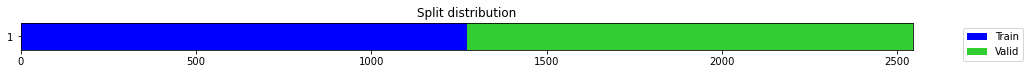

WandbCallback could not retrieve the dataset path, please provide it explicitly to "log_dataset"
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,accuracy,time
0,0.588768,0.563394,0.869599,00:00
1,0.511317,0.455561,0.869599,00:00
2,0.464871,0.421021,0.869599,00:00
3,0.442810,0.419079,0.869599,00:00
4,0.428243,0.418058,0.869599,00:00
5,0.417575,0.407211,0.869599,00:00
6,0.409314,0.403258,0.869599,00:00
7,0.402786,0.399853,0.869599,00:00
8,0.395842,0.395180,0.869599,00:00
9,0.392936,0.393068,0.869599,00:00


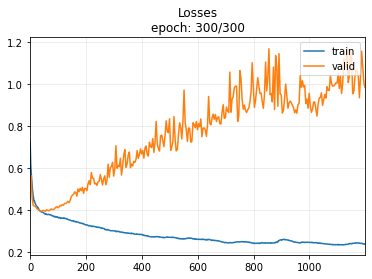

accuracy,█████▄█▇▇▁▄█▄▅▆▅▅▄▁▅▇▇▄▇▇▇▆▄▅▃▆▅▄▅▆▅▅▇▅▄
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,█▅▆▆▆▆▃▇▅▄▃▃▃▃▃▄▃▄▃▄▂▂▂▂▃▄▄▂▁▄▃▂▂▄▁▂▁▃▄▂
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁
train_samples_per_sec,▆▆█▄▃▄▅▄▁▁▂▄▃▅▂▃▄▄▂▅▂▃▃▄▄▄▃▅▂▄▂▃▂▂▁▄▄▃▃▃
valid_loss,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▆▅▅▆▆▆▆▆▆▆▅▇▅▆▆▇█▇▆
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


AttributeError: Exception occured in `WandbCallback` when calling event `after_fit`:
	'MLSTM_FCN' object has no attribute 'save_model'

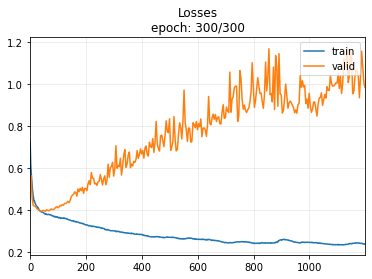

In [16]:
config = AttrDict(
    batch_tfms = TSStandardize(by_sample=True),
    arch_config = {},
    architecture = MLSTM_FCN,
    lr = 1e-3,
    n_epochs = 300,
)
learner_FCN = multivariate_classification_wandb(X_all, y_all, splits, config = config, lr_find=False, load_ckpt = False, proj_name = "50-1 V2X MLSTM_FCN TSClassification")

# inference

loaded 3 files
['./data/1-Cycle\\0926_821OJMMY.csv', './data/1-Cycle\\0926_MCPSLU1U.csv', './data/1-Cycle\\0926_OHGY9ZSV.csv'] ...
files index: 0 ~ 3


100%|██████████| 3/3 [00:00<00:00,  3.19it/s]

X_sum shape: (2546, 9, 10), y_sum shape: (2546,)
Dataset Info is...
X shape: (2546, 9, 10), y shape: (2546,)
splits: (train: (#1273)(0, ...)) (test: (#1273)(1273, ...))
# True in y: (array([0, 1]), array([2219,  327], dtype=int64))
Dataset Info is done.
X      - shape: [2546 samples x 9 features x 10 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (2546,)  type: ndarray  dtype:int32  isnan: 0
splits - n_splits: 2 shape: [1273, 1273]  overlap: False


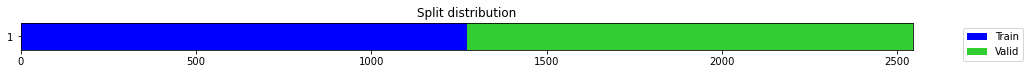

In [13]:
inf_path = './data/1-Cycle'

v2xdata = V2XData(inf_path, hazard_thr=3)
X_inf, y_inf, splits, df = v2xdata.get_all_item()
v2xdata.get_data_info(X_inf, y_inf, splits)

check_data(X_inf, y_inf, splits=splits)

In [130]:
tfms = [None, [Categorize()]]
batch_tfms = TSStandardize(by_sample=True)
dsets = TSDatasets(X, y, tfms=tfms)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
model = create_model(MLSTM_FCNPlus, dls = dls)
learner = Learner(dls, model, metrics=accuracy)
learner.load('model')

array([0, 0, 1, ..., 1, 0, 0])

In [15]:
# load model
# learner = load_learner_all(path='models', dls_fname='dls', model_fname='model', learner_fname='learner')
dls = learner.dls
valid_dl = dls.valid

# add Labelled test data
test_ds = valid_dl.dataset.add_test(X, y) # test data
test_dl = valid_dl.new(test_ds)
test_probas, test_targets, test_preds = learner.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')
print(f'precision: {skm.precision_score(test_targets, test_preds):10.6f}')
print(f'recall: {skm.recall_score(test_targets, test_preds):10.6f}')
print(f'f1: {skm.f1_score(test_targets, test_preds):10.6f}')

# compare on table
test_preds_tensor = torch.tensor(test_preds)
compare_table = pd.DataFrame([test_targets, test_preds_tensor]).T

NameError: name 'learner' is not defined

In [27]:
learner

<function print>

TensorBase(0.9207)


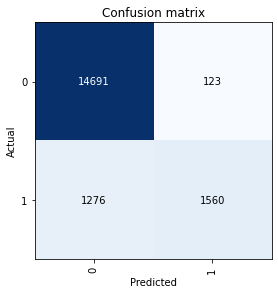

In [86]:
print((valid_targets == valid_preds).float().mean())
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

# end inference

epoch,train_loss,valid_loss,accuracy,time
0,2.074216,3.687134,0.111111,00:02
1,1.649432,2.281937,0.189781,00:02
2,1.362581,1.479431,0.528792,00:02
3,1.154527,1.228426,0.599757,00:02
4,0.991463,1.085312,0.637064,00:02
5,0.860411,1.063518,0.662612,00:02
6,0.751722,1.110025,0.650852,00:02
7,0.657632,1.061910,0.669505,00:02
8,0.575983,1.050900,0.669505,00:02
9,0.504939,1.119205,0.667883,00:02


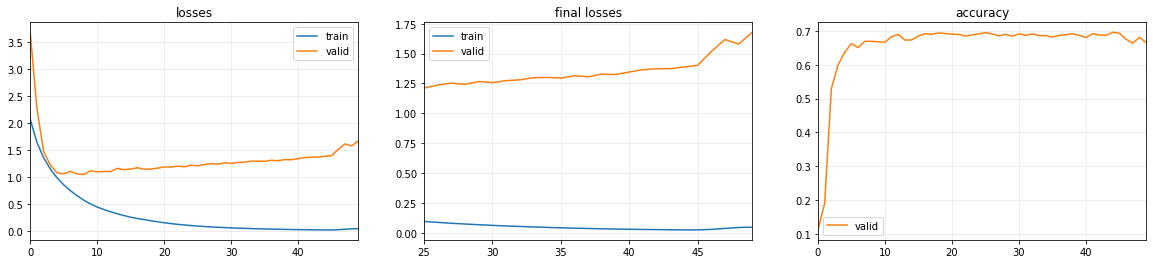

In [54]:
minirocket_classification(X, y, splits, epochs=50, model=MiniRocketPlus, lr = 1e-3, metrics=accuracy, lr_find=False)

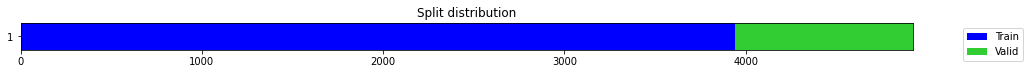

epoch,train_loss,train_mae,valid_loss,valid_mae,time
0,4035.176270,57.598530,8170.714844,90.389160,00:00
1,3939.350830,55.636570,8094.535645,89.966507,00:00


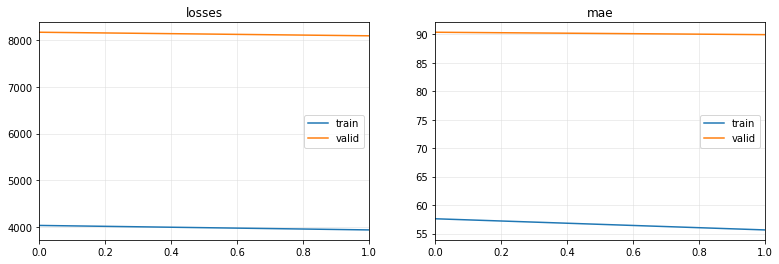

In [33]:
multivariate_forecasting(X_all, y_all, splits, epochs=2, model=LSTM, lr = 1e-3, lr_find=False)

# TS Classification

epoch,train_loss,valid_loss,accuracy,time
0,0.610862,0.637526,0.789474,00:00
1,0.543891,0.588012,0.789474,00:00
2,0.480455,0.515660,0.789474,00:00
3,0.419447,0.551365,0.789474,00:00
4,0.367510,0.679785,0.789474,00:00
5,0.335073,0.668797,0.789474,00:00
6,0.310686,0.607035,0.789474,00:00
7,0.293726,0.631922,0.789474,00:00
8,0.279131,0.639701,0.789474,00:00
9,0.268276,0.642383,0.789474,00:00


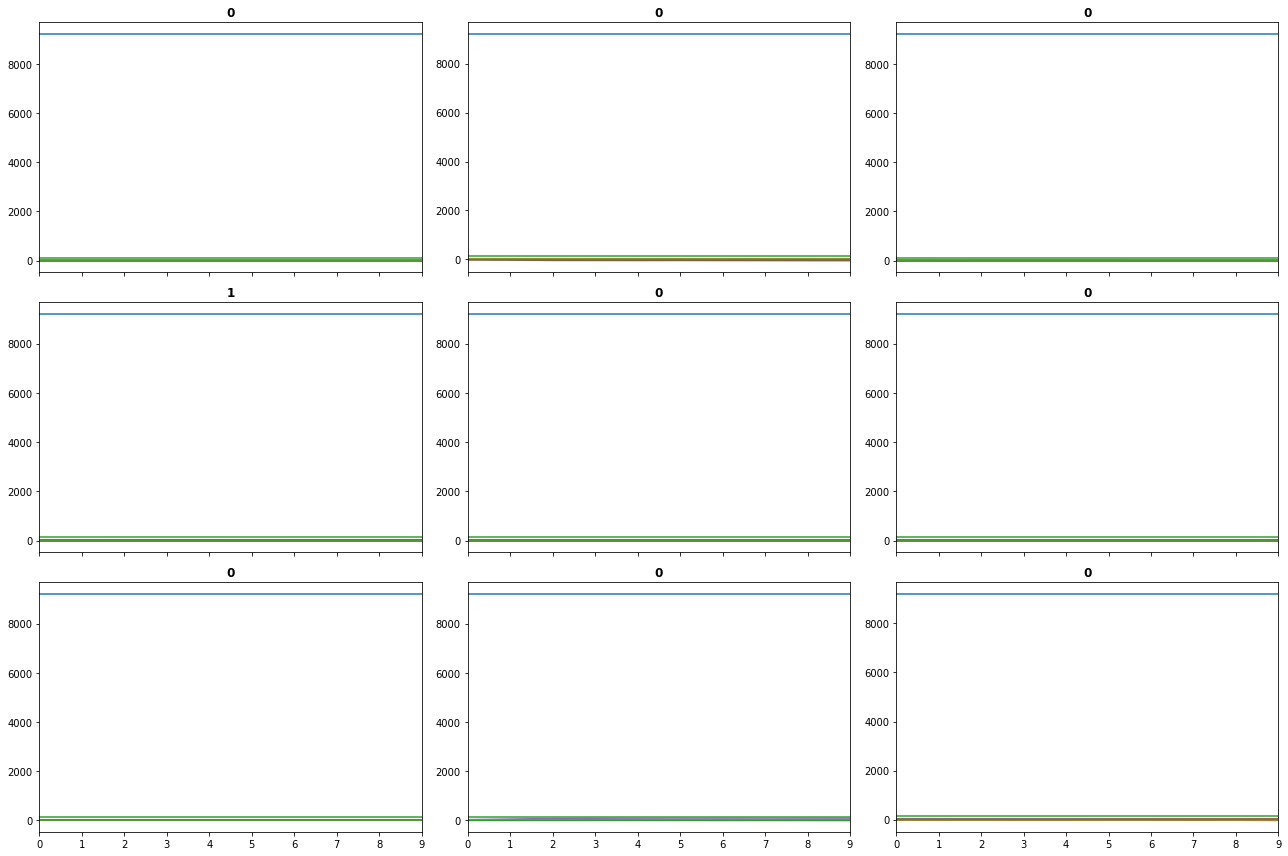

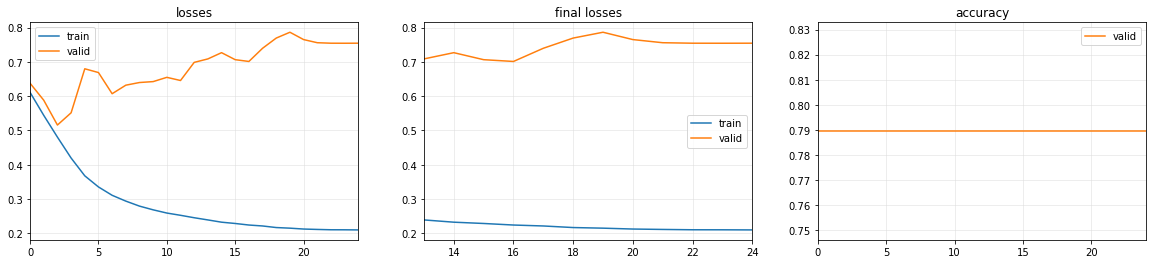

In [16]:
# train with LSTM
tfms = [TSStandardize(verbose=True), [Categorize()]]
batch_tfms = TSStandardize(by_sample=True)
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=64, batch_tfms=None)
dls.show_batch()

model = create_model(LSTM_FCN, dls = dls)
learn = Learner(dls, model, metrics=accuracy)
learn.fit_one_cycle(25, 1e-3)
learn.plot_metrics()                                                                                 

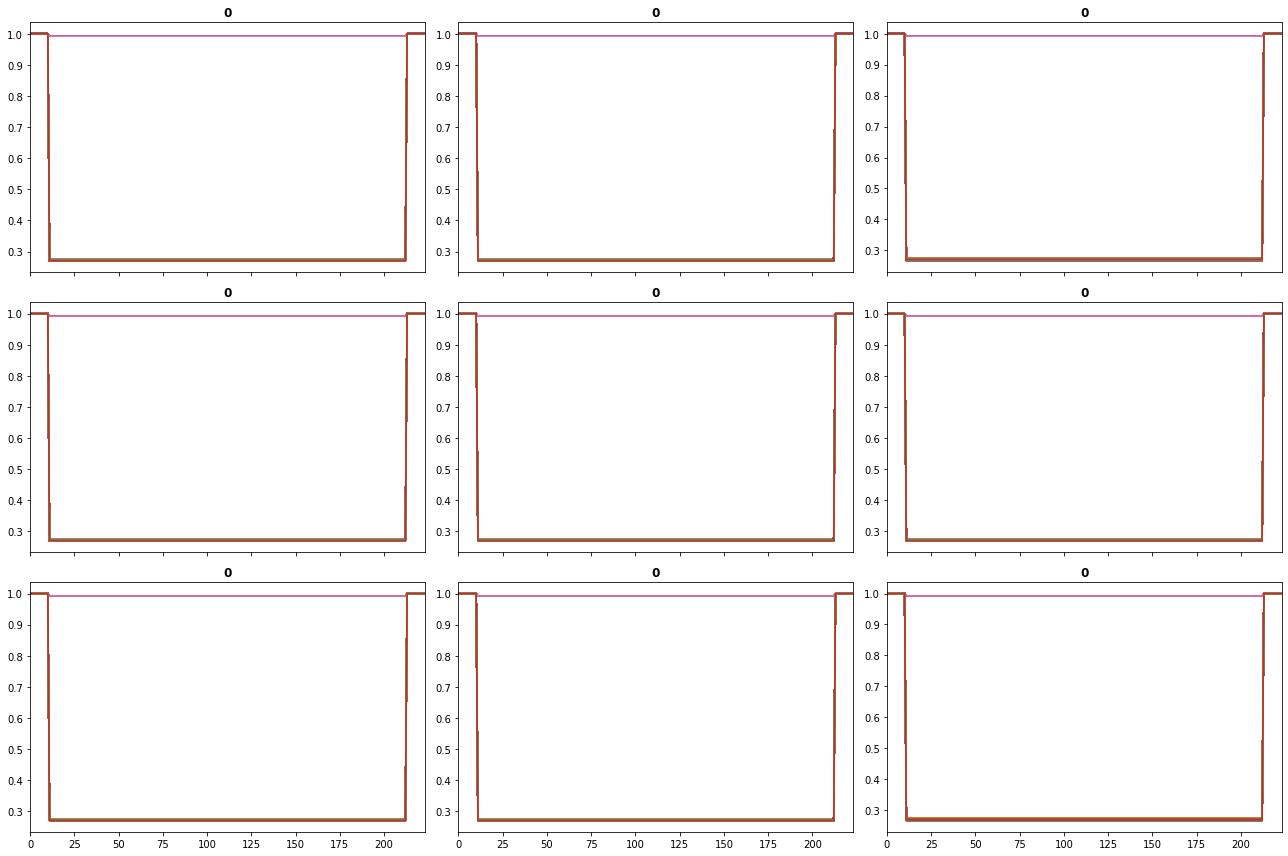

In [15]:
tfms = [None, Categorize()]
batch_tfms = [TSNormalize(), TSToMat()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms)
dls.show_batch()

# load labled data

In [1]:
from v2x import V2XData,V2XDataLabeled

data_path = './data/raw/220901/C/A'

v2xdata = V2XDataLabeled(data_path)

X, y, splits, df = v2xdata[1]

print(X[0, :, :3])
print(y[:3])
print(v2xdata.get_data_info(X, y, splits))
len(y[y == 'False'])

loaded 0 files
[] ...
loaded 7 scenarios
['./data/raw/220901/C/A\\70CE06E7', './data/raw/220901/C/A\\70CE0799', './data/raw/220901/C/A\\70CE07CA', './data/raw/220901/C/A\\70CE0A0B', './data/raw/220901/C/A\\70CE0AD2'] ...
[[9240.        9240.        9240.       ]
 [ 126.9012861  126.9012861  126.9012863]
 [  35.142656    35.1426558   35.1426555]
 [   0.           0.           0.       ]
 [   0.           0.           0.       ]
 [   0.           0.           0.       ]
 [   0.           0.           0.       ]]
['False' 'False' 'Right']
Dataset Info is...
X shape: (618, 7, 10), y shape: (618,)
splits: (train: (#309)(0, ...)) (test: (#309)(309, ...))
# True in y: (array(['False', 'Left', 'Reverse', 'Right'], dtype='<U7'), array([601,   6,   1,  10], dtype=int64))
Dataset Info is done.
None


601

X      - shape: [618 samples x 7 features x 10 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (618,)  type: ndarray  dtype:<U7  n_classes: 4 (154 samples per class) ['False', 'Left', 'Reverse', 'Right']  isnan: False
splits - n_splits: 2 shape: [309, 309]  overlap: False


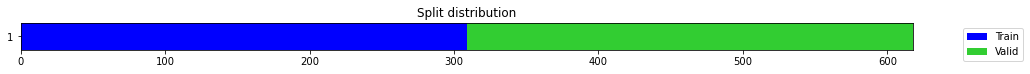

epoch,train_loss,valid_loss,accuracy,time
0,1.477269,1.432092,0.000000,00:00
1,1.454377,1.388226,0.000000,00:00
2,1.432305,1.345999,0.000000,00:00
3,1.410664,1.304519,0.000000,00:00
4,1.389392,1.263073,0.980583,00:00
5,1.367807,1.220985,0.980583,00:00
6,1.346546,1.177620,0.980583,00:00
7,1.324371,1.132305,0.980583,00:00
8,1.302012,1.084343,0.980583,00:00
9,1.278785,1.032951,0.980583,00:00


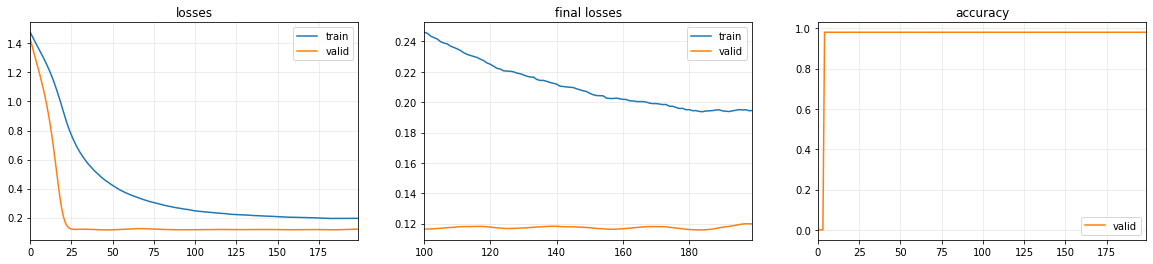

In [4]:
learner = multivariate_classification(X, y, splits, epochs=200, model=LSTM, lr = 1e-3, metrics=accuracy, lr_find=False)

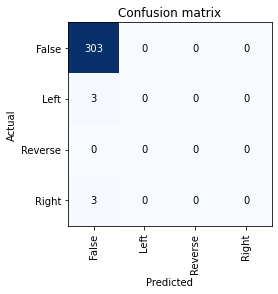

In [5]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()